In [33]:
!pip install jax jaxlib

/srv/conda/envs/notebook/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [34]:
import numpy as np
import sys
from functools import partial
import netCDF4 as nc
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import grad, lax,jit

from functools import partial

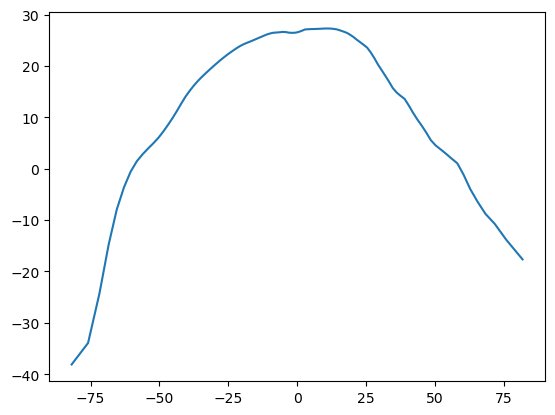

In [35]:
# Let's set up our grid
N = 100 # number of grid points

XEDGES = jnp.linspace(-1.0, 1.0, N + 1)
X = 0.5 * (XEDGES[:-1] + XEDGES[1:])
LAT = jnp.arcsin(X) * 180.0 / jnp.pi
DX = X[1] - X[0]

## Import NCEP temperature, get zonal mean and extrapolate to grid size
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_Ts = nc.Dataset( ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc" )
lat_ncep = ncep_Ts.variables['lat']; lon_ncep = ncep_Ts.variables['lon']
Ts_ncep_annual = np.mean(ncep_Ts.variables['skt'][:], axis=(0,2) )
Ts_annual_interp = np.interp(LAT,np.array(lat_ncep[::-1]),Ts_ncep_annual[::-1])

fig, (ax,ax2) = plt.subplots(2,1, sharex=True, figsize=(7,6))
ax.set_title('One control')
ax.plot(LAT, Ts_annual_interp)
ax.set_ylabel(r'Temperature ($^{\circ}C)$')
ax.set_xlabel('Latitude')

## One control: albedo

In [36]:
def budyko_sellers_jax_1c(XXS):
    MAX_ITER = 1000  # Reduce if needed for speed

    # Load target temperatures and convert to jax array
    TARGET_DT = jnp.array(np.loadtxt('T_zonalmean_NCEP.dat'))

    # Constants
    S0 = 1366.0
    Q = S0 / 4.0
    SIGMA = 5.67e-8
    EPSILON = 0.63
    DIFF = 0.6

    XEDGES = jnp.linspace(-1.0, 1.0, N + 1)
    X = 0.5 * (XEDGES[:-1] + XEDGES[1:])
    LAT = jnp.arcsin(X) * 180.0 / jnp.pi
    DX = X[1] - X[0]

    SX = Q * (1.0 - 0.482 * X**2) * 1.35 - 55.0 + XXS[:]

    # Initial temperature
    T_init = 288.0 + 60.0 * (1.0 - X**2) - 20.0

    DT = DX**2 / (2.0 * (DIFF)) * 0.5
    alpha0 = 0.354
    alpha2 = 0.25

    def step(T, _):
        ALPHA = alpha0 + alpha2 * (1.5 * jnp.sin(jnp.radians(LAT))**2 - 0.5) 
        ALPHA = jnp.log(ALPHA / (1.0 - ALPHA)) + 1*XXS
        ALPHA = 1.0 / (1.0 + jnp.exp(-ALPHA))

        FIN = SX * (1.0 - ALPHA)
        FOUT = EPSILON * SIGMA * T**4

        DTDX_M = jnp.concatenate([jnp.array([0.0]), (T[1:] - T[:-1]) / DX])
        DTDX_P = jnp.concatenate([(T[1:] - T[:-1]) / DX, jnp.array([0.0])])

        FDIFF = DIFF * ((1 - XEDGES[1:]**2) * DTDX_P -
                        (1 - XEDGES[:-1]**2) * DTDX_M) / DX

        T_new = T + DT * (FIN - FOUT + FDIFF)
        return T_new, ALPHA

    T_final, _ = lax.scan(step, T_init, None, length=MAX_ITER)
    alpha_raw = alpha0 + alpha2 * (1.5 * jnp.sin(jnp.radians(LAT))**2 - 0.5) 
    logits = jnp.log(alpha_raw / (1.0 - alpha_raw)) + 1*XXS
    ALPHA = 1.0 / (1.0 + jnp.exp(-logits))
    # Cost: L2 norm between T_final and TARGET_DT (converted from K to C)
    J = jnp.sqrt(jnp.sum((T_final - TARGET_DT - 273.0)**2))
    return J,T_final,ALPHA

def cost_fxn_1c(XXS):
    J,_,_ = budyko_sellers_jax_1c(XXS)
    return J

In [37]:
grad_J = grad(cost_fxn_1c)
XXS_1c = jnp.zeros(100)
dJ_dXXS_1c = grad_J(XXS_1c) 
# grad_J?

In [38]:
## gradient descent
XXS_1c = jnp.zeros(N)
ETA = 1
max_iter = 400
J1c = 1000 # Something above threshold to initialize J1c in while loop
i = 0
while((J1c > 85) & (i < max_iter)):
    J1c, T1c, alpha1c = budyko_sellers_jax_1c(XXS_1c)
    g = grad_J(XXS_1c)
    print(f'Cost function at step {i}: {J1c}')
    XXS_1c = XXS_1c - ETA*g
    i = i+1

Cost function at step 0: 199.63856506347656
Cost function at step 1: 140.0075225830078
Cost function at step 2: 105.86982727050781
Cost function at step 3: 97.59740447998047
Cost function at step 4: 93.80070495605469
Cost function at step 5: 91.62294006347656
Cost function at step 6: 90.23212432861328
Cost function at step 7: 89.27468872070312
Cost function at step 8: 88.57701110839844
Cost function at step 9: 88.04670715332031
Cost function at step 10: 87.6294174194336
Cost function at step 11: 87.29190063476562
Cost function at step 12: 87.01256561279297
Cost function at step 13: 86.77618408203125
Cost function at step 14: 86.57373809814453
Cost function at step 15: 86.39815521240234
Cost function at step 16: 86.24378967285156
Cost function at step 17: 86.10667419433594
Cost function at step 18: 85.98419189453125
Cost function at step 19: 85.87259674072266
Cost function at step 20: 85.77268981933594
Cost function at step 21: 85.6800537109375
Cost function at step 22: 85.5960845947265

Text(0.5, 0, 'Latitude')

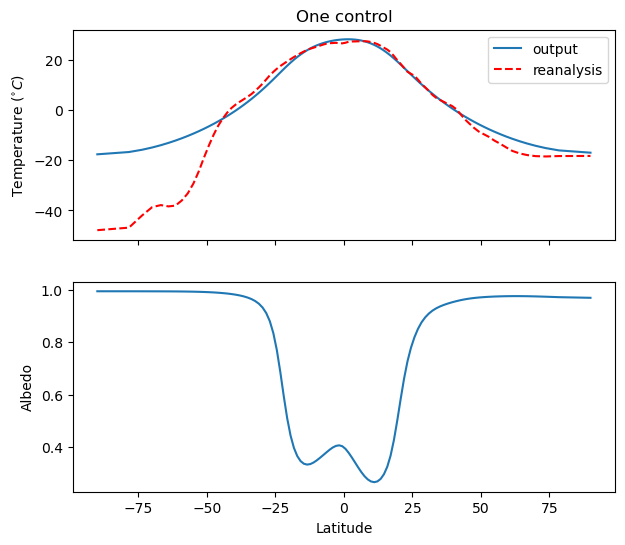

In [39]:
lat = np.arcsin(np.linspace(-1.0, 1.0, 100)) * 180.0 / jnp.pi
T_ncep = jnp.array(np.loadtxt('T_zonalmean_NCEP.dat'))

fig, (ax,ax2) = plt.subplots(2,1, sharex=True, figsize=(7,6))
ax.set_title('One control')
ax.plot(lat, T1c-273)
ax.plot(lat,T_ncep,'--r')
ax.legend(('output','reanalysis'), bbox_to_anchor=(1,1))
ax.set_ylabel(r'Temperature ($^{\circ}C)$')

ax2.plot(lat, alpha1c)
ax2.set_ylabel('Albedo')
ax2.set_xlabel('Latitude')

## Two controls: albedo and emissivity

In [50]:
def budyko_sellers_jax_2c(XXS):
    MAX_ITER = 1000  # Reduce if needed for speed

    # Load target temperatures and convert to jax array
    TARGET_DT = jnp.array(np.loadtxt('T_zonalmean_NCEP.dat'))

    # Constants
    S0 = 1366.0
    Q = S0 / 4.0
    SIGMA = 5.67e-8
    EPSILON = 0.63
    DIFF = 0.6

    XEDGES = jnp.linspace(-1.0, 1.0, N + 1)
    X = 0.5 * (XEDGES[:-1] + XEDGES[1:])
    LAT = jnp.arcsin(X) * 180.0 / jnp.pi
    DX = X[1] - X[0]

    SX = Q * (1.0 - 0.482 * X**2) * 1.35 - 55.0 + XXS[:N]

    # Initial temperature
    T_init = 288.0 + 60.0 * (1.0 - X**2) - 20.0

    DT = DX**2 / (2.0 * (DIFF)) * 0.5
    alpha0 = 0.354
    alpha2 = 0.25

    def step(T, _):
        ALPHA = alpha0 + alpha2 * (1.5 * jnp.sin(jnp.radians(LAT))**2 - 0.5)
        ALPHA = jnp.log(ALPHA / (1.0 - ALPHA)) + 1*XXS[:N]
        ALPHA = 1.0 / (1.0 + jnp.exp(-ALPHA))

        emiss_logit = jnp.log(EPSILON/(1.0-EPSILON)) + 1*XXS[N:]
        emiss = 1.0/(1.0+ jnp.exp(emiss_logit))

        FIN = SX * (1.0 - ALPHA)
        FOUT = (emiss) * SIGMA * T**4

        DTDX_M = jnp.concatenate([jnp.array([0.0]), (T[1:] - T[:-1]) / DX])
        DTDX_P = jnp.concatenate([(T[1:] - T[:-1]) / DX, jnp.array([0.0])])

        FDIFF = DIFF * ((1 - XEDGES[1:]**2) * DTDX_P -
                        (1 - XEDGES[:-1]**2) * DTDX_M) / DX

        T_new = T + DT * (FIN - FOUT + FDIFF)
        return T_new, ALPHA

    T_final, _ = lax.scan(step, T_init, None, length=MAX_ITER)
    alpha_raw = alpha0 + alpha2 * (1.5 * jnp.sin(jnp.radians(LAT))**2 - 0.5)
    logits = jnp.log(alpha_raw / (1.0 - alpha_raw)) + 1*XXS[:N]
    ALPHA = 1.0 / (1.0 + jnp.exp(-logits))
    emiss_logit = jnp.log(EPSILON/(1.0-EPSILON)) + 1.0*XXS[N:]
    emiss = 1.0/(1.0+ jnp.exp(-emiss_logit))
    # Cost: L2 norm between T_final and TARGET_DT (converted from K to C)
    J = jnp.sqrt(jnp.sum((T_final - TARGET_DT - 273.0)**2))
    return J,T_final,ALPHA,emiss

def cost_fxn_2c(XXS):
    J,_,_,_ = budyko_sellers_jax_2c(XXS)
    return J

In [42]:
grad_J = grad(cost_fxn_2c)
XXS = jnp.zeros(2*N)
dJ_dXXS = grad_J(XXS) 
# grad_J?

In [44]:
## gradient descent
XXS = jnp.zeros(2*N)

a = 1
max_iter = 400
J = 1000
i = 0
while((J > 50) & (i < max_iter)):
    J,T,alpha,emiss = budyko_sellers_jax_2c(XXS)
    g = grad_J(XXS)
    print(f'Cost function at step {i}: {J}')
    XXS = XXS - a*g
    i = i+1

Cost function at step 0: 352.6409606933594
Cost function at step 1: 108.42089080810547
Cost function at step 2: 66.28453826904297
Cost function at step 3: 59.246978759765625
Cost function at step 4: 62.24681854248047
Cost function at step 5: 84.26960754394531
Cost function at step 6: 77.22257995605469
Cost function at step 7: 84.88085174560547
Cost function at step 8: 53.650917053222656
Cost function at step 9: 53.09034729003906
Cost function at step 10: 52.300071716308594
Cost function at step 11: 52.032569885253906
Cost function at step 12: 51.45248031616211
Cost function at step 13: 51.25775146484375
Cost function at step 14: 50.806453704833984
Cost function at step 15: 50.644649505615234
Cost function at step 16: 50.29298400878906
Cost function at step 17: 50.15410232543945
Cost function at step 18: 49.88151168823242


Text(0.5, 0, 'Latitude')

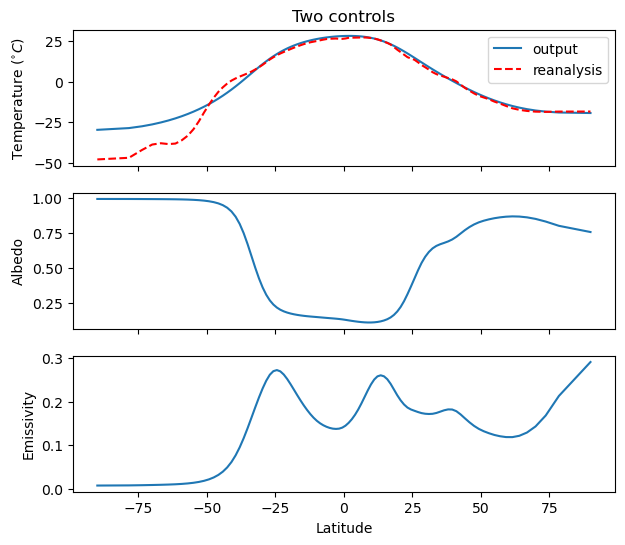

In [45]:
import matplotlib.pyplot as plt
lat = np.arcsin(np.linspace(-1.0, 1.0, 100)) * 180.0 / jnp.pi
T_ncep = jnp.array(np.loadtxt('T_zonalmean_NCEP.dat'))

fig, (ax,ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(7,6))
ax.set_title('Two controls')
ax.plot(lat, T-273)
ax.plot(lat,T_ncep,'--r')
ax.legend(('output','reanalysis'), bbox_to_anchor=(1,1))
ax.set_ylabel(r'Temperature ($^{\circ}C)$')

ax2.plot(lat, alpha)
ax2.set_ylabel('Albedo')

ax3.plot(lat, emiss)
ax3.set_ylabel('Emissivity')
ax3.set_xlabel('Latitude')

## Normalizing control vector

Right now albedo and emissivity have equal "weights" within the control vector although their typical magnitudes are different. We can normalize the control vector by dividing it by an uncertainties vector that will have the value of the uncertainties for each control (say the typical magnitude of their variations).

let's do alpha=0.1
and epsilon=0.001

In [59]:
def cost_norm(u, UNCER):
    # Map normalized u → physical controls XXS
    XXS = u * UNCER
    J, _, _, _ = budyko_sellers_jax_2c(XXS)
    return J

unc_alpha = [1,0.1,0.1,0.5]
unc_emiss = [1,0.1,0.01,0.1]
T_norm = jnp.zeros((len(unc_alpha),N))
alpha_norm = jnp.zeros((len(unc_alpha),N))
emiss_norm = jnp.zeros((len(unc_alpha),N))
J_norm = jnp.zeros(len(unc_alpha))

for Dalpha, Demiss, ii in zip(unc_alpha, unc_emiss, range(3)):
    # Initialize normalized parameters
    u = jnp.zeros(2 * N)
    eta = 1
    max_iter = 500
    
    # Uncertainties for normalization
    UNCER = jnp.concatenate([Dalpha * jnp.ones(N), Demiss * jnp.ones(N)])
    # Gradient of the normalized cost
    grad_u = grad(lambda u: cost_norm(u, UNCER))
    
    for i in range(max_iter):
        J_val = cost_norm(u, UNCER)
        g = grad_u(u)
        if J_val < 50.0:
            break
        u = u - eta * g
    print(f"Delta alpha = {Dalpha:.5f} and Delta epsilon = {Demiss:.5f}")
    print(f"Step {i:03d}: J = {J_val:.6f}, ||grad|| = {jnp.linalg.norm(g):.2e}")
         
    # Recover optimal physical controls
    XXS_opt = u * UNCER
    J_n, T_n, alpha_n, emiss_n = budyko_sellers_jax_2c(XXS_opt)
    J_norm = J_norm.at[ii].set(J_n)
    T_norm = T_norm.at[ii,:].set(T_n)
    alpha_norm = alpha_norm.at[ii,:].set(alpha_n)
    emiss_norm = emiss_norm.at[ii,:].set(emiss_n)

Delta alpha = 1.00000 and Delta epsilon = 1.00000
Step 018: J = 49.881512, ||grad|| = 1.50e+00
Delta alpha = 0.10000 and Delta epsilon = 0.10000
Step 499: J = 55.182018, ||grad|| = 1.30e-01
Delta alpha = 0.10000 and Delta epsilon = 0.01000
Step 499: J = 147.621765, ||grad|| = 2.14e-01


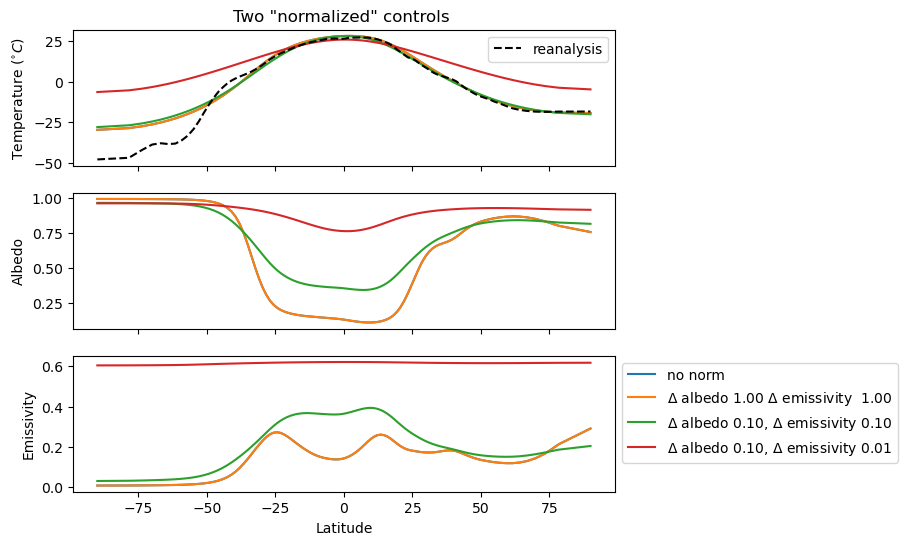

In [60]:
fig, (ax,ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(7,6))
ax.set_title('Two "normalized" controls ')
ax.plot(lat, T-273)
ax.plot(lat, T_norm[0,:]-273)
ax.plot(lat, T_norm[1,:]-273)
ax.plot(lat, T_norm[2,:]-273)

ax.plot(lat,T_ncep,'--k', label='reanalysis')
ax.legend( bbox_to_anchor=(1,1))
ax.set_ylabel(r'Temperature ($^{\circ}C)$')

ax2.plot(lat, alpha)
ax2.plot(lat, alpha_norm[0,:])
ax2.plot(lat, alpha_norm[1,:])
ax2.plot(lat, alpha_norm[2,:])
ax2.set_ylabel('Albedo')

ax3.plot(lat, emiss, label='no norm')
ax3.plot(lat, emiss_norm[0,:], label=(r'$\Delta$ albedo %1.2f $\Delta$ emissivity  %1.2f' %(unc_alpha[0],unc_emiss[0])))
ax3.plot(lat, emiss_norm[1,:], label=r'$\Delta$ albedo %1.2f, $\Delta$ emissivity %1.2f' %(unc_alpha[1],unc_emiss[1]))
ax3.plot(lat, emiss_norm[2,:], label=r'$\Delta$ albedo %1.2f, $\Delta$ emissivity %1.2f' %(unc_alpha[2],unc_emiss[2]))

ax3.set_ylabel('Emissivity')
ax3.set_xlabel('Latitude')
ax3.legend(bbox_to_anchor=(1,1))

What if we allow uncertainty to vary with latitude. For example, we would expect albedo to vary more where we have regions of ice/snow that melt (higher uncertainies), vs regions where there never is ice/snow (lower uncertainties)?

In [64]:
T_norm2 = jnp.zeros((N))
alpha_norm2 = jnp.zeros((N))
emiss_norm2 = jnp.zeros((N))

# Initialize normalized parameters
u = jnp.zeros(2 * N)
eta = 1
max_iter = 500

# Uncertainties for normalization
Dalpha1 = 0.1
Dalpha2 = 0.8
Dalpha_var = Dalpha2*jnp.ones(N)
Dalpha_var = Dalpha_var.at[10:-10].set(Dalpha1)

UNCER = jnp.concatenate([Dalpha_var, Demiss * jnp.ones(N)])

# Gradient of the normalized cost
grad_u = grad(lambda u: cost_norm(u, UNCER))

for i in range(max_iter):
    J_val = cost_norm(u, UNCER)
    g = grad_u(u)
    if J_val < 50.0:
        break
    u = u - eta * g
print(f"Delta alpha = {Dalpha:.5f} and Delta epsilon = {Demiss:.5f}")
print(f"Step {i:03d}: J = {J_val:.6f}, ||grad|| = {jnp.linalg.norm(g):.2e}")
     
# Recover optimal physical controls
XXS_opt = u * UNCER
J_n, T_n, alpha_n, emiss_n = budyko_sellers_jax_2c(XXS_opt)
J_norm2 = J_n
T_norm2 = T_norm2.at[:].set(T_n)
alpha_norm2 = alpha_norm2.at[:].set(alpha_n)
emiss_norm2 = emiss_norm2.at[:].set(emiss_n)

Delta alpha = 0.10000 and Delta epsilon = 0.01000
Step 499: J = 142.571487, ||grad|| = 1.81e-01


ValueError: x and y must have same first dimension, but have shapes (100,) and (1, 100)

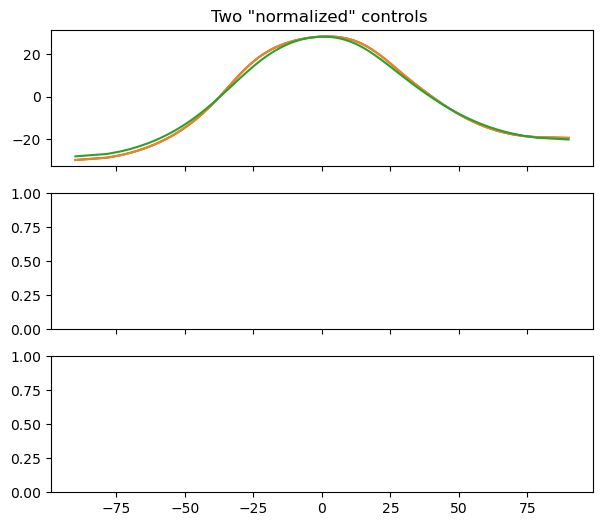

In [63]:
fig, (ax,ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(7,6))
ax.set_title('Two "normalized" controls ')
ax.plot(lat, T-273)
ax.plot(lat, T_norm[0,:]-273)
ax.plot(lat, T_norm[1,:]-273)
ax.plot(lat, T_norm2[:]-273)

ax.plot(lat,T_ncep,'--k', label='reanalysis')
ax.legend( bbox_to_anchor=(1,1))
ax.set_ylabel(r'Temperature ($^{\circ}C)$')

ax2.plot(lat, alpha)
ax2.plot(lat, alpha_norm[0,:])
ax2.plot(lat, alpha_norm[1,:])
ax2.plot(lat, alpha_norm2[:])
ax2.set_ylabel('Albedo')

ax3.plot(lat, emiss, label='no norm')
ax3.plot(lat, emiss_norm[0,:], label=(r'$\Delta$ albedo %1.2f $\Delta$ emissivity  %1.2f' %(unc_alpha[0],unc_emiss[0])))
ax3.plot(lat, emiss_norm[1,:], label=r'$\Delta$ albedo %1.2f, $\Delta$ emissivity %1.2f' %(unc_alpha[1],unc_emiss[1]))
ax3.plot(lat, emiss_norm2[:], label=r'varying' )

ax3.set_ylabel('Emissivity')
ax3.set_xlabel('Latitude')
ax3.legend(bbox_to_anchor=(1,1))

For Earth as a whole (i.e. the “planetary” emitter), you don’t behave like a perfect blackbody. To match the outgoing long-wave radiation at a surface temperature of 288 K (15 °C), you need an effective emissivity of roughly 0.61. This is the factor ε in
F=ε σ T4
F=εσT4

that brings the Stefan–Boltzmann flux into balance with absorbed solar energy.
Dutton Institute
Wikipedia

At the surface itself, broadband long-wave emissivities are much higher—most natural materials emit very efficiently in the thermal infrared. Observations in the 8–13 μm “atmospheric window” give:

    Surface emissivity ranges from about 0.65 (bare desert) up to 0.99 (wet or vegetated regions), with most land and ocean surfaces above 0.9, yielding a global average near 0.95.
    Wikipedia

    Ocean emissivity specifically is measured at 0.96–0.99 over 1–100 μm, and ~0.98–0.99 in the 8–14 μm window used for sea-surface-temperature retrieval.

Here are the key “albedo” numbers you’ll often see for Earth:

    Planetary (Bond) albedo
    The fraction of all incoming solar radiation that Earth scatters back to space.
    AEarth≈0.29–0.31
    AEarth​≈0.29–0.31

    – NASA/UCAR report an average of about 31 %
    Center for Science Education

    – Wikipedia (Bond albedo) lists 0.294
    Wikipedia

    Surface albedos (visible/near-IR, vary strongly by land-cover)
    Wikipedia
    :
    Surface type	Typical albedo
    Open ocean	0.06
    Conifer forest (summer)	0.08 – 0.15
    Deciduous forest	0.15 – 0.18
    Grassland	∼0.25
    Bare soil	∼0.17
    Desert sand	∼0.40
    Fresh concrete	∼0.55
    Sea ice	0.50 – 0.70
    Fresh snow	0.80 – 0.85

    Atmospheric/cloud albedo
    Clouds boost Earth’s overall reflectivity; depending on type, cloud-top albedo ranges up to 0.8, and with ~50 % cloud cover contributes heavily to the planetary average
    Wikipedia
    .

Which albedo to use in an EBM?

    For a global 1-D energy balance model you normally set
    Ap≈0.30
    Ap​≈0.30

    as the planetary albedo (incorporating land, ocean, ice and clouds).

    If you want to resolve latitude bands, you’d assign each band its surface albedo (as above) plus a latitude

    -dependent cloud fraction to approximate the total reflectance.



Uncertainties
| albedo| emissivity|notes|
|:-:|:-:|:-:|
|1|1|Step 014: J = 49.999809, grad = 9.87e-01, eta=1|
|0.1|0.1|Step 131: J = 49.982227, grad = 4.64e-02 but did eta=10|
|0.1|0.01||